# This notebook contains the final figures for the SILVR paper

In [1]:
import pandas as pd

df = pd.read_csv("experiments/data_all.csv")
len(df)

7028

In [2]:
print(len(df[df["auto3d_rmsd"].notna()]))
print(len(df[df["is_fragmented"]==False]))
print(len(df[df["auto3d_rmsd"].notna()])/len(df[df["is_fragmented"]==False]))

4481
4597
0.9747661518381553


In [3]:
from matplotlib import pyplot as plt

def get_data_to_plot(df, exps, metric):
    make_100x = True
    ignore_nan = True
    plotting_data = []
    
    #labels = []
    
    for exp in exps:
        if ignore_nan:
            metric_value = df[(df["exp_id"] == exp) & df[metric].notna()][metric]
        else:
            metric_value = df[df["exp_id"] == exp][metric]
        plotting_data.append(metric_value)
        
        #labels.append(str(df[df["exp_id"] == exp]["silvr"].iloc[0]*100))
    

    return plotting_data


def get_plot_labels(df, exps, make_100x=True):
    labels = []
    for exp in exps:
        labels.append(str(df[df["exp_id"] == exp]["silvr"].iloc[0]*100))
    return labels

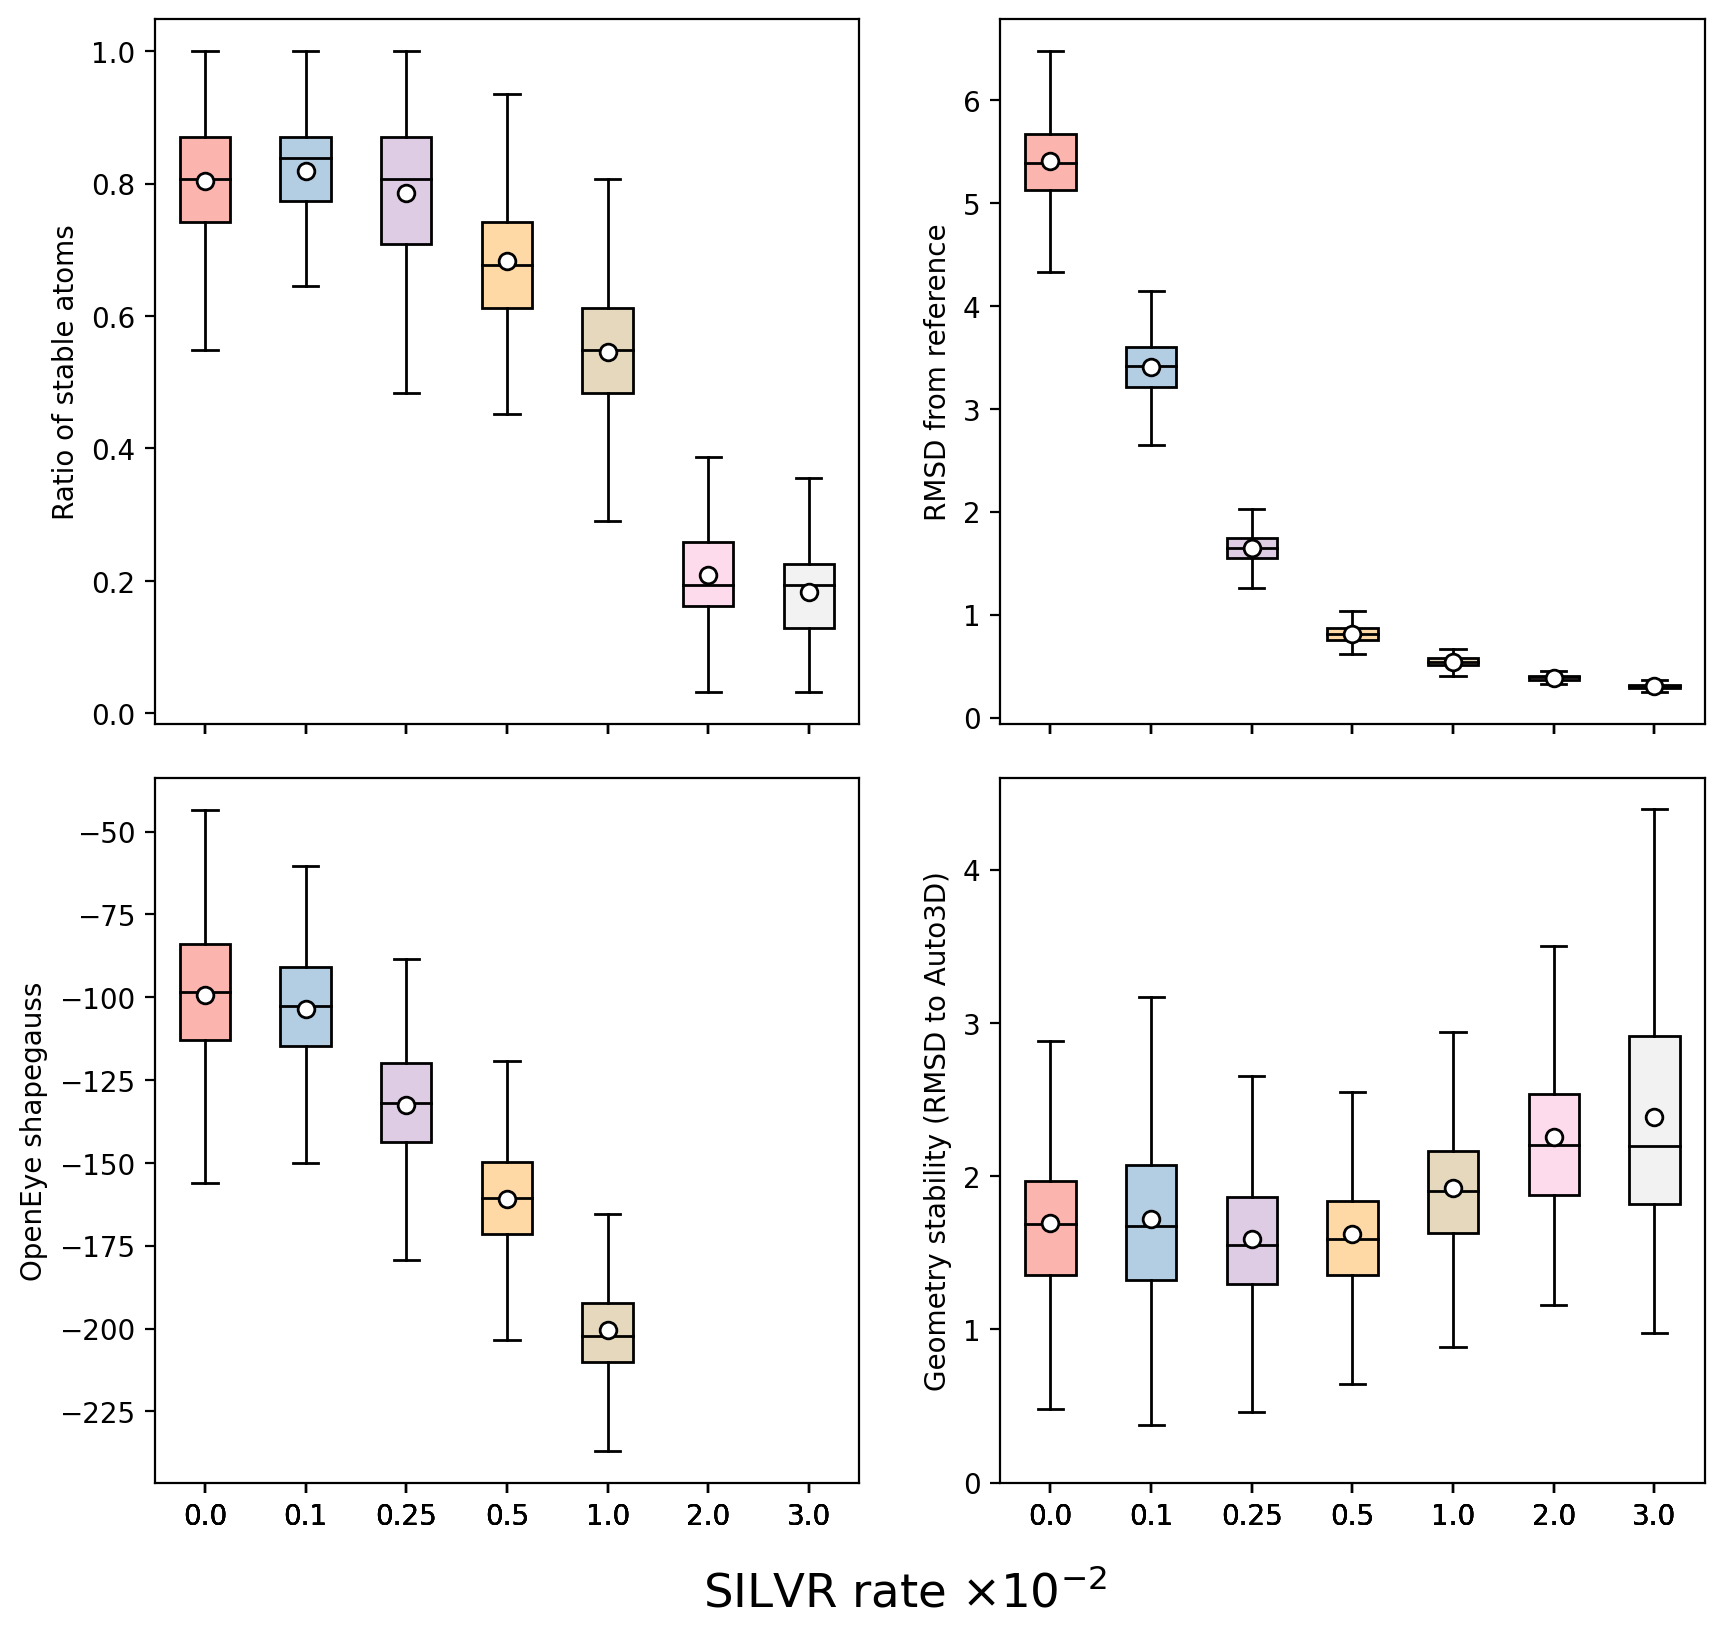

In [4]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np


#-----Data to plot---------
#These experiments need to be redone without the dummy atoms
ordered_exp_names = ["exp_22","exp_23","exp_24","exp_25","exp_26","exp_27","exp_28"] #list(exp_df.sort_values("silvr")["exp_id"])
#selected_df = df[df["is_fragmented"]==False]

#selected_df = df


#Make horizontal line black for readability!!!!!!!!


#-----Plot setup--------
#fig = plt.figure(figsize=(5, 5), dpi=80)
#ax = fig.add_subplot()

#plt.subplots(figsize=(6, 2))
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200,
                        #constrained_layout=True,
                        subplot_kw=dict(box_aspect=1),sharex=True)
#fig.tight_layout(pad=1)
meanpointprops = dict(marker='o', markeredgecolor='black',
                      markerfacecolor='white')

plt.rcParams['font.size'] = '14'
xlabel = r"SILVR rate $\times 10^{-2}$"

#-----plotting---------------


#since all plots share the same label
labels = get_plot_labels(df, ordered_exp_names)


#------------------[0,0] atom stability------------------
plotting_data = get_data_to_plot(df, ordered_exp_names, "stable_ratio")
box00 = axs[0,0].boxplot(plotting_data,labels=labels, showfliers=False, patch_artist=True, showmeans=True,meanprops=meanpointprops)
axs[0,0].set(ylabel='Ratio of stable atoms')
#axs[0,0].set_title('A',loc='left')



#------------------[0,1] RMSD from reference------------------
plotting_data = get_data_to_plot(df, ordered_exp_names, "crude_rmsd")
box01 = axs[0,1].boxplot(plotting_data,labels=labels, showfliers=False, patch_artist=True, showmeans=True,meanprops=meanpointprops)
axs[0,1].set(ylabel='RMSD from reference')
#axs[0,1].set_title('B',loc='left')




#------------------[1,0] shapegauss------------------
plotting_data = get_data_to_plot(df[df["shapegauss"]<200], ordered_exp_names, "shapegauss")

#Note: for SILVR=0.02 and 0.03 only 8 and 1 shapegauss value actually passes
#These are removed from the analysis as points are not representative
#plotting_data[-1] = [-50]
#plotting_data[-2] = [-50]
box10 = axs[1,0].boxplot(plotting_data,labels=labels, showfliers=False, patch_artist=True, showmeans=True,meanprops=meanpointprops)
axs[1,0].set(ylabel='OpenEye shapegauss',
             #xlabel=xlabel
            )
#axs[1,0].set_title('C',loc='left')



#------------------[1,1] Geometric stability------------------
#!!!! Using rmsd column
plotting_data = get_data_to_plot(df[(df["is_fragmented"]==False) & (df["auto3d_rmsd"].notna())], ordered_exp_names, "auto3d_rmsd")
box11 = axs[1,1].boxplot(plotting_data,labels=labels, showfliers=False, patch_artist=True, showmeans=True,meanprops=meanpointprops)
axs[1,1].set(ylabel='Geometry stability (RMSD to Auto3D)',
             #xlabel=xlabel
             yticks = [0, 1, 2,3,4],#Forcing the axis labels to be integers
            )
#axs[1,1].set_title('D',loc='left')



#------------------Make plot look nice------------------

#fig.text(0.5, 0, xlabel, ha='center')
plt.subplots_adjust(wspace=0.2, hspace=0.01)
fig.supxlabel(xlabel,y=0.07)

#----colors----
n_boxes = len(ordered_exp_names)
colors = cm.Pastel1(np.linspace(0, 1, n_boxes))


boxes = [box00,box01,box10,box11]
for box in boxes:
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        
    for median in box['medians']:
        median.set_color('black')
        
        
#plt.savefig('figures/figures/fig_3_metrics.png')

In [5]:
df["qed"].notna().groupby(df["silvr"]).value_counts(True)[::2].mean()

0.9482071713147411

<AxesSubplot:title={'center':'Percentage of successful OB/RDKit reads'}, xlabel='SILVR rate', ylabel='Percentage of molecules\nread by RDKit'>

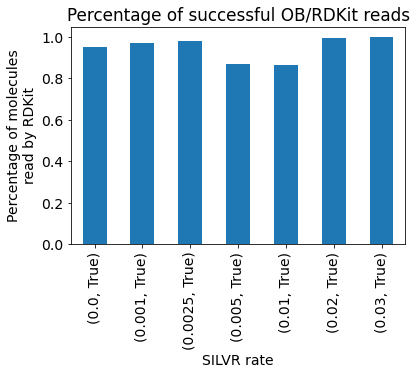

In [6]:
df["qed"].notna().groupby(df["silvr"]).value_counts(True)[::2].plot(kind="bar", title="Percentage of successful OB/RDKit reads",xlabel="SILVR rate", ylabel="Percentage of molecules\nread by RDKit")

In [7]:
df["auto3d_rmsd"].mean()

1.9541617565713383

In [8]:
df["auto3d_rmsd"].groupby(df["silvr"]).mean()

silvr
0.0000    1.697015
0.0010    1.717544
0.0025    1.593062
0.0050    1.621824
0.0100    1.921205
0.0200    2.256644
0.0300    2.382887
Name: auto3d_rmsd, dtype: float64

# SI measures

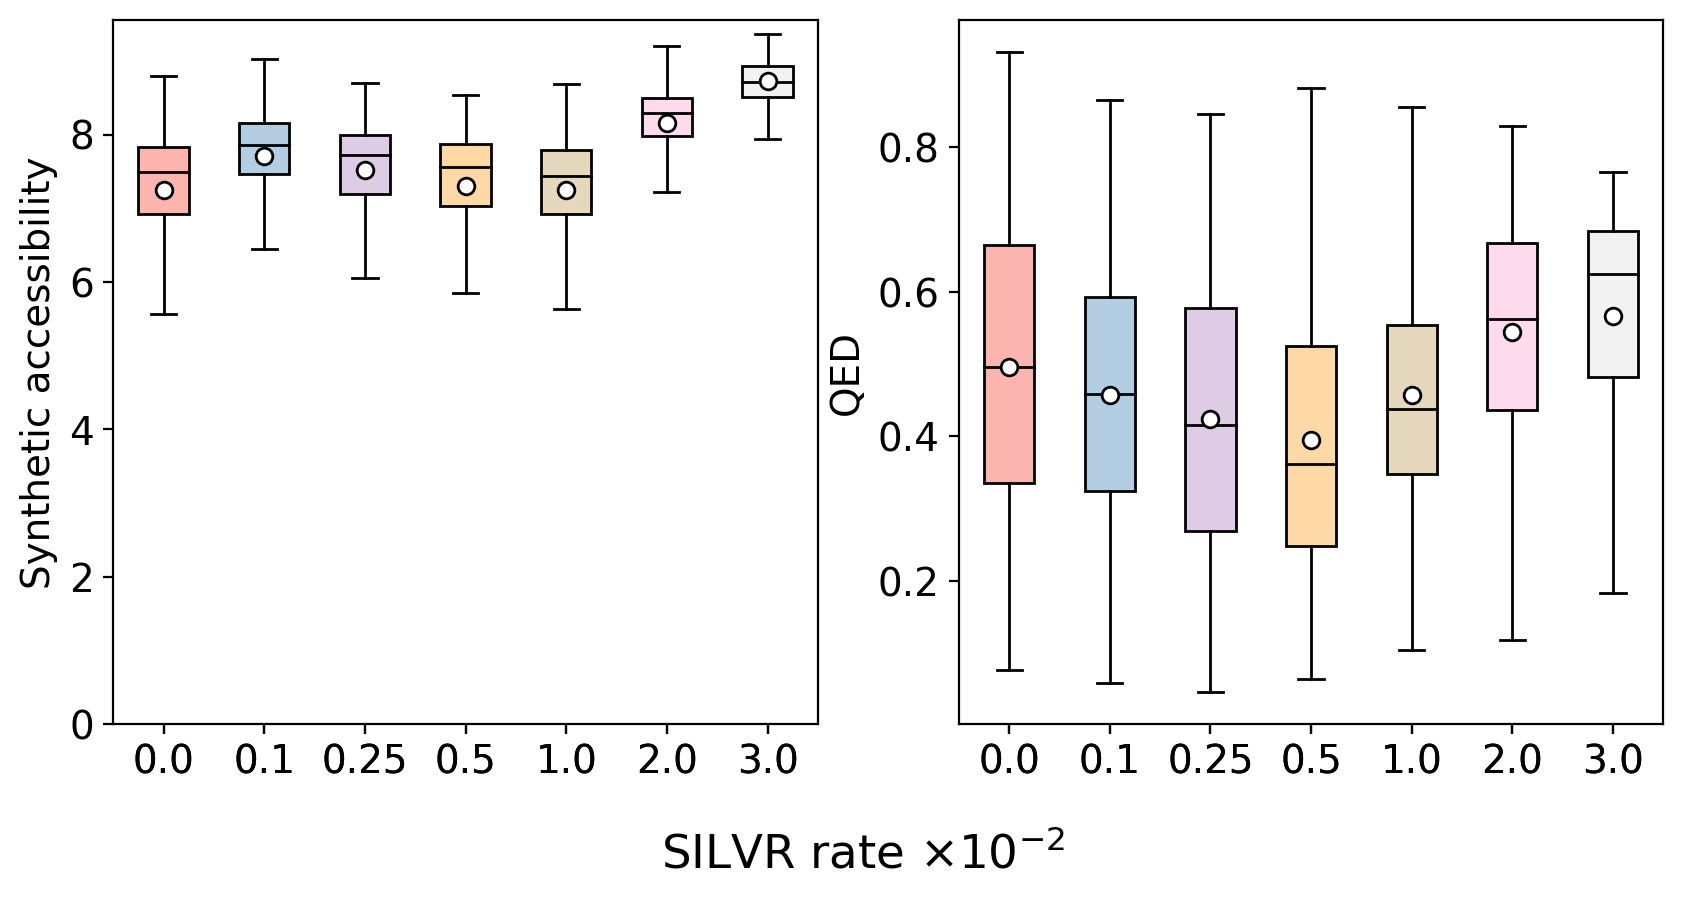

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=200,
                        #constrained_layout=True,
                        subplot_kw=dict(box_aspect=1),sharex=True,
                       facecolor='white')
#fig.tight_layout(pad=1)
meanpointprops = dict(marker='o', markeredgecolor='black',
                      markerfacecolor='white')

plt.rcParams['font.size'] = '14'
xlabel = r"SILVR rate $\times 10^{-2}$"

#-----plotting---------------


#since all plots share the same label
#labels = get_plot_labels(df, ordered_exp_names)

non_fragmented_df = df[df["is_fragmented"]==False]
#non_fragmented_df = df

#------------------[0,0] synthetic accessibility------------------
plotting_data = get_data_to_plot(non_fragmented_df, ordered_exp_names, "sa")
box00 = axs[0].boxplot(plotting_data,labels=labels, showfliers=False, patch_artist=True, showmeans=True,meanprops=meanpointprops)
axs[0].set(ylabel='Synthetic accessibility')
axs[0].set_ylim(bottom=0)

#axs[0,0].set_title('A',loc='left')


#------------------[0,1] QED------------------
plotting_data = get_data_to_plot(non_fragmented_df, ordered_exp_names, "qed")
box01 = axs[1].boxplot(plotting_data,labels=labels, showfliers=False, patch_artist=True, showmeans=True,meanprops=meanpointprops)
axs[1].set(ylabel='QED')
#axs[0,1].set_title('B',loc='left')




#------------------Make plot look nice------------------

#fig.text(0.5, 0, xlabel, ha='center')
plt.subplots_adjust(wspace=0.2, hspace=0.01)
fig.supxlabel(xlabel,y=0.25)

#----colors----
n_boxes = len(ordered_exp_names)
colors = cm.Pastel1(np.linspace(0, 1, n_boxes))


boxes = [box00, box01]
for box in boxes:
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        
    for median in box['medians']:
        median.set_color('black')
        
        

plt.savefig('figures/figures/si_fig_2d_measures.png')